<a href="https://colab.research.google.com/github/barrosm/text_mining/blob/master/trabalho_final_Monica_Barros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monica Barros #
# Trabalho final de BI #
## df entrega: 08/02/2020 ##

## Crie uma wordcloud para empresa e para estado e outra para serviço com intuito de saber qual é a empresa com mais reclamações.

## No problema retire os dados null, faça uma tokenização e logo um stopwords crie depois uma wordcloud. 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Informações sobre a placa NVDIA da VM (se houver)
!nvidia-smi  #comando da placa nvdia pra saber o que está rodando

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
import os
workdir_path = '/content/drive/My Drive/BIMaster_2019/trabalho_leonardo/' 
os.chdir(workdir_path)


## Inicialização #


In [12]:

!pip install nltk
import nltk


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import seaborn as sns; 
sns.set(rc={'figure.figsize':(17,6)})

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Exibe diretório atual e versões de principais módulos
current_dir = os.getcwd()
print('')
print('Diretório Atual: ',current_dir)
print('')
print('Versão Pandas :', pd.__version__)
print('')
print('Versão Numpy :', np.__version__)
print('')
print('Versão Seaborn :', sns.__version__)




Diretório Atual:  /content/drive/My Drive/BIMaster_2019/trabalho_leonardo

Versão Pandas : 0.25.3

Versão Numpy : 1.17.4

Versão Seaborn : 0.9.0


Versão Pandas : 0.25.3
Versão Numpy : 1.17.4


NameError: ignored

## Leitura dos Dados ##

In [0]:
df = pd.read_csv('base reclamações.csv')
df.head()

,user_id,stars,reviews
0,A2XP9IN4JOMROD,1,I wanted to love this. I was even prepared for...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups were excellent. T...
2,AJ3L5J7GN09SV,2,I bought the Grove Square hazelnut cappuccino ...
3,A3CZD34ZTUJME7,1,"I love my Keurig, and I love most of the Keuri..."
4,AWKN396SHAQGP,1,It's a powdered drink. No filter in k-cup.<br ...


In [0]:
df.tail()

,user_id,stars,reviews
537,A398T38COTS30K,5,This is my favorite K-Cup flavor. I like my c...
538,A1B410YK9O18XZ,5,If you are looking for the taste of French Van...
539,A1W85A81467TCW,5,I have purchased and used 3 boxes of the Hazel...
540,A103FOM06QPAX8,5,"Yummy, great tasting and very convenient. Onl..."
541,A1V5V04WIYLT8Q,4,"For an enjoyable change from a coffee routine,..."


## Desafio 1 ##

* Determine quantas revisões existem no total.
* Determine o percentual de 1, 2, 3, 4 e 5 estrelas.
* Crie um novo conjunto de dados para modelagem com as seguintes colunas:
      - Coluna 1: 'positivo' se revisão = 4 ou 5 e 'negativo' se revisão = 1 ou 2
      - Coluna 2: texto de revisão
* Veja o número de análises positivas e negativas no conjunto de dados recém-criado.

Ponto de verificação: o conjunto de dados resultante deve ter 514 revisões.

Use o código de pré-processamento abaixo para limpar os dados das revisões antes de passar para a modelagem.

In [0]:
# Número de revisões
df.shape[0]

542

In [0]:
# Enquanto a maioria dos revisores deixa uma avaliação de 5 estrelas, também há uma boa parte deixando avaliações de 1 estrela
df.stars.value_counts(normalize=True)

5    0.568266
1    0.177122
4    0.119926
2    0.083026
3    0.051661
Name: stars, dtype: float64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 3 columns):
user_id    542 non-null object
stars      542 non-null int64
reviews    542 non-null object
dtypes: int64(1), object(2)
memory usage: 12.8+ KB


In [0]:
import numpy as np

# Remover comentários de 3 estrelas
df = df[df.stars!=3]

# Defina 4/5 estrelas como positivas, o resto como negativo
df['sentiment'] = np.where(df['stars'] >= 4, 'positive', 'negative')

# Incluir apenas as colunas de opinião e comentários
df = df[['sentiment', 'reviews']]
df.head()

,sentiment,reviews
0,negative,I wanted to love this. I was even prepared for...
1,positive,Grove Square Cappuccino Cups were excellent. T...
2,negative,I bought the Grove Square hazelnut cappuccino ...
3,negative,"I love my Keurig, and I love most of the Keuri..."
4,negative,It's a powdered drink. No filter in k-cup.<br ...


In [0]:
# Check the length of the new dfset
len(df)

514

In [0]:
# Verifique o comprimento do novo conjunto de dados
df.sentiment.value_counts(normalize=True)

positive    0.725681
negative    0.274319
Name: sentiment, dtype: float64

In [0]:
# Etapas de pré-processamento de texto - remova números, letras maiúsculas e pontuação
import re
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['reviews'] = df.reviews.map(alphanumeric).map(punc_lower)
df.head()

,sentiment,reviews
0,negative,i wanted to love this i was even prepared for...
1,positive,grove square cappuccino cups were excellent t...
2,negative,i bought the grove square hazelnut cappuccino ...
3,negative,i love my keurig and i love most of the keuri...
4,negative,it s a powdered drink no filter in k cup br ...


## Desafio 2 ##

Prepare os dados para modelagem:
* Divida os dados em conjuntos de treinamento e teste. Você deve ter quatro conjuntos de dados - X_train, X_test, y_train, y_test

Crie recursos numéricos com o Count Vectorizer. Crie duas matrizes de termo do documento:
* Matriz 1: os termos devem ser unigramas (palavras únicas) e os valores devem ser contados por palavras (dica: esse é o padrão do vetor de contagem)
* Matriz 2: os termos devem ser unigramas e bigrams e os valores devem ser valores binários

Recomendação: Utilize a função de palavras de parada do Count Vectorizer para remover palavras de parada do texto das revisões.

In [0]:
# Divida os dados em conjuntos de dados X e y
X = df.reviews
y = df.sentiment

In [0]:
# Divida os dados em conjuntos de treinamento e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
# Número de revisões no conjunto de treinamento
X_train.shape, y_train.shape

((359,), (359,))

In [0]:
# Número de revisões no conjunto de testes
X_test.shape, y_test.shape

((155,), (155,))

In [0]:
# A primeira matriz de termo de documento possui valores padrão de vetor de contagem - contagem de unigramas
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)  # NOTE QUE FIT SÓ É FEITO NA BASE DE TREINO, E NÃO NA DE TESTE

print(X_train_cv1.toarray().shape)

(359, 1638)


In [0]:
# A segunda matriz de termos de documento possui unigramas e bigrams e indicadores em vez de contagens
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train) # NOTE QUE FIT SÓ É FEITO NA BASE DE TREINO, E NÃO NA DE TESTE

X_test_cv2  = cv2.transform(X_test)

print(X_train_cv2.toarray().shape)  # Note o número de colunas bem maior que no modelo anterior

(359, 7792)


## Desafio 3 ##

Use a regressão logística para classificar as críticas como positivas ou negativas. Faça isso para ambas as matrizes.
* Ajuste um modelo de regressão logística nos dados de treinamento
* Aplique o modelo nos dados de teste e calcule as seguintes métricas de erro: exatidão, precisão, recall, pontuação F1
* Opcional: visualize a matriz de confusão para os dois modelos
* Compare as métricas de erro das duas matrizes

Recomendação: Crie uma função para calcular as métricas de erro, pois você fará isso várias vezes.

In [0]:
# Crie um modelo de regressão logística para usar
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [0]:
# Treine o primeiro modelo (note que usa as features do modelo cv1)
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# Treine o segundo modelo (usa as features do modelo cv2 - bigrams)
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# Crie uma função para calcular as métricas de erro, pois faremos isso várias vezes
from __future__ import division
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    
    a = true_pos + true_neg
    b = true_pos + true_neg + false_pos + false_neg
    print (a/b)
    
    accuracy = round(float((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)),3)
    precision = round(float((true_pos) / (true_pos + false_pos)),3)
    recall = round(float((true_pos) / (true_pos + false_neg)),3)
    f1 = round(float(2 * (precision * recall) / (precision + recall)),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

0.864516129032258


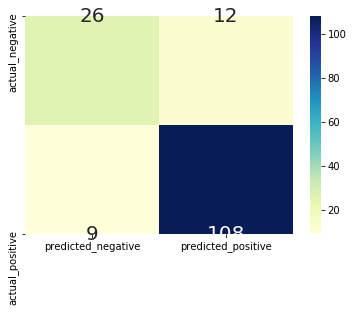

In [0]:
# To mapa de calor para o primeiro modelo de regressão logística
cm1 = conf_matrix(y_test, y_pred_cv1)

0.8774193548387097


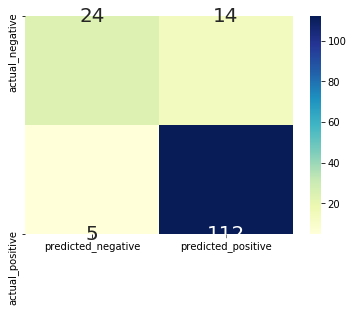

In [0]:
# O mapa de calor para o segundo modelo de regressão logística
cm2 = conf_matrix(y_test, y_pred_cv2)

In [0]:
# Compile todas as métricas de erro em um quadro de dados para comparação
results = pd.dfFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.865,0.877
Precision,0.900,0.889
Recall,0.923,0.957
F1 Score,0.911,0.922


Comparando os dois modelos, o primeiro modelo tem melhor precisão, enquanto o segundo modelo tem melhor acurácia e recall. PODERIA MELHORAR REBALANCEANDO A BASE.

## Desafio 4 ##

tentamos usar outra técnica de aprendizado de máquina para classificar essas análises como positivas ou negativas. Siga exatamente o mesmo exercício na etapa anterior, mas desta vez use Naive Bayes em vez de Regressão logística.

Para dados de contagem, use [Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). Para dados binários, use [Bernoulli Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB).

Compare os resultados dos modelos Regressão Logística e Naive Bayes.

In [0]:
# Ajuste o primeiro modelo Naive Bayes
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [0]:
# Ajuste o segundo modelo Naive Bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

0.8838709677419355


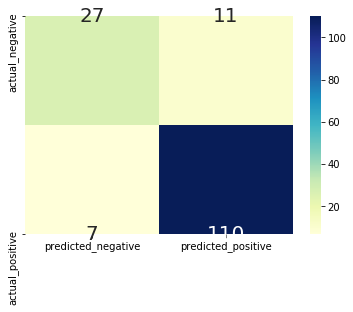

In [0]:
# Aqui está o mapa de calor para o primeiro modelo Naive Bayes
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

0.7612903225806451


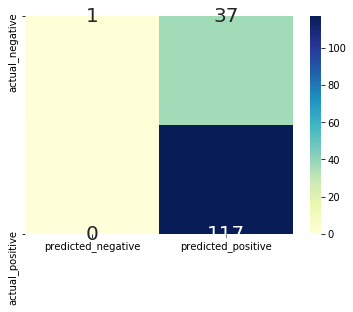

In [0]:
# Aqui está o mapa de calor para o segundo modelo Naive Bayes
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [0]:
# Compile todas as métricas de erro em um quadro de dados para comparação
results_nb = pd.dfFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.865,0.877,0.884,0.761
Precision,0.900,0.889,0.909,0.760
Recall,0.923,0.957,0.940,1.000
F1 Score,0.911,0.922,0.924,0.864


O primeiro modelo Naive Bayes supera os dois modelos de regressão logística.

## Desafio 5 ##

Até o momento, usamos o Count Vectorizer para criar matrizes de termos de documentos para inserir nos modelos. Para pelo menos um dos quatro modelos que você criou até agora, use o TF-IDF Vectorizer em vez do Count Vectorizer e verifique se ele melhora os resultados.

De todos os modelos que você criou, qual modelo você acha que classifica melhor as críticas positivas e negativas para a xícara de cappuccino?

In [0]:
# Crie versões TF-IDF dos vetorizadores de contagem criados anteriormente no exercício
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [0]:
# Ajuste a primeira regressão logística nos dados do TF-IDF
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

In [0]:
# Ajuste a segunda regressão logística nos dados do TF-IDF
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

It looks like using TF-IDF, we were able to improve the recall, but the accuracy and precision of the first Naive Bayes model still outperforms the other models.

Overall, the first Naive Bayes model (using unigrams and counts) seems to best classify positive and negative cappuccino cup reviews.